In [1]:
%load_ext autoreload
%autoreload 2

import itertools

import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from netcal.metrics import ECE
import robustness_metrics as rm
import sklearn
import tensorflow as tf

import random

from utils_notebook import get_logits_targets, modal_probs_decreasing, f_probs_ovr_poe_logits_weighted_generalized, get_scale_probs
from utils_conformal import conformalize_anytime_nn, conformalize_anytime_nn_raps
from utils_uncertainty import oracle_collab_acc_np, temper_probs, get_ood_scores, get_ood_detection_roc

import seaborn as sns
import scipy

2023-04-06 18:14:08.972851: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-06 18:14:09.111692: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-06 18:14:09.761222: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-04-06 18:14:09.761292: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

In [2]:
import matplotlib
# import Line2D for custom legends
from matplotlib.lines import Line2D
 

text_width = 5.50107 # in  --> Confirmed with template explanation
dpi = 300

fs_m1 = 6  # for figure ticks
fs = 8  # for regular figure text
fs_p1 = 9 #  figure titles

matplotlib.rc('font', size=fs)          # controls default text sizes
matplotlib.rc('axes', titlesize=fs)     # fontsize of the axes title
matplotlib.rc('axes', labelsize=fs)    # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=fs_m1)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=fs_m1)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=fs_m1)    # legend fontsize
matplotlib.rc('figure', titlesize=fs_p1, dpi=dpi, autolayout=True)  # fontsize of the figure 
matplotlib.rc('lines', linewidth=1, markersize=3)
matplotlib.rc('savefig', dpi=1200, bbox='tight')
matplotlib.rc('grid', alpha=0.3)
matplotlib.rc('axes', grid=True)

matplotlib.rc('font', **{'family':'serif', 'serif': ['Palatino']})
matplotlib.rc('text', usetex=True)
# matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

In [3]:
MODEL_FOLDER = 'models'
LIKELIHOOD = 'softmax'
EPOCH = 299

logits, targets, ARGS = get_logits_targets('cifar100', MODEL_FOLDER, LIKELIHOOD, EPOCH)

L = len(logits)
N = len(targets)

building network of steps: 
[4, 2, 2, 2, 2, 2, 2] 16
 ********************** Block 1  **********************
|		inScales 3 outScales 3 inChannels 16 outChannels 6		|

|		inScales 3 outScales 3 inChannels 22 outChannels 6		|

|		inScales 3 outScales 3 inChannels 28 outChannels 6		|

|		inScales 3 outScales 3 inChannels 34 outChannels 6		|

 ********************** Block 2  **********************
|		inScales 3 outScales 3 inChannels 40 outChannels 6		|

|		inScales 3 outScales 3 inChannels 46 outChannels 6		|

 ********************** Block 3  **********************
|		inScales 3 outScales 2 inChannels 52 outChannels 6		|
|		Transition layer inserted! (max), inChannels 58, outChannels 29	|

|		inScales 2 outScales 2 inChannels 29 outChannels 6		|

 ********************** Block 4  **********************
|		inScales 2 outScales 2 inChannels 35 outChannels 6		|

|		inScales 2 outScales 2 inChannels 41 outChannels 6		|

 ********************** Block 5  **********************
|		inScales 2 outS

In [4]:
probs = torch.softmax(logits, dim=2)
preds = {i: torch.argmax(probs, dim=2)[i, :] for i in range(L)}

In [5]:
T = 1.
probs_poe_ovr_break_ties_generalized = torch.tensor(f_probs_ovr_poe_logits_weighted_generalized(logits, weights=(np.arange(1, L + 1, 1, dtype=float) / L) * T))
preds_poe_ovr_break_ties_generalized = {i: torch.argmax(probs_poe_ovr_break_ties_generalized, dim=2)[i, :] for i in range(L)}
acc_poe_ovr_break_ties_generalized = [(targets == preds_poe_ovr_break_ties_generalized[i]).sum() / len(targets) for i in range(L)]

In [6]:
scaled_dict = get_scale_probs(['PoE-OVR (tempered)'], [probs_poe_ovr_break_ties_generalized], [2.], targets, C=ARGS.num_classes, L=L)
probs_poe_ovr_break_ties_generalized_tempered = scaled_dict['PoE-OVR (tempered)'][2.0][0]

In [7]:
_probs_poe_ovr_break_ties_generalized_tempered = temper_probs(probs_poe_ovr_break_ties_generalized, .5)
_probs_poe_ovr_break_ties_generalized_tempered_multi = temper_probs(
    probs_poe_ovr_break_ties_generalized,
    np.array([0.20, 0.25 ,0.30, 0.35, 0.4, 0.45, 0.5])[:, None, None]).to(torch.float32)

In [8]:
def make_stateful(probs):
    _probs_stateful = []
    for n in range(N):
        probs_stateful_all = []
        max_prob_all, max_id = 0., 0.
        for l in range(L):
            _max_prob = probs[l, n, :].max()
            if _max_prob >= max_prob_all:
                max_prob_all = _max_prob
                prob_stateful_all = probs[l, n, :]
                max_id = l
            else:
                prob_stateful_all = probs[max_id, n, :]
            probs_stateful_all.append(prob_stateful_all)
        _probs_stateful.append(torch.stack(probs_stateful_all))

    _probs_stateful = torch.stack(_probs_stateful)

    probs_stateful = _probs_stateful.permute(1, 0, 2)

    return probs_stateful

In [9]:
probs_stateful = make_stateful(probs)
preds_stateful = {i: torch.argmax(probs_stateful, dim=2)[i, :] for i in range(L)}
acc_stateful = [(targets == preds_stateful[i]).sum() / len(targets) for i in range(L)]

In [10]:
acc_stateful

[tensor(0.6514),
 tensor(0.6957),
 tensor(0.7258),
 tensor(0.7421),
 tensor(0.7473),
 tensor(0.7494),
 tensor(0.7516)]

In [11]:
logits_poe = logits.cumsum(dim=0) / torch.tensor([float(x) for x in range(1, L + 1)])[:, None, None]
probs_poe = torch.softmax(logits_poe, dim=2)
preds_poe = {i: torch.argmax(probs_poe, dim=2)[i, :] for i in range(L)}
acc_poe = [(targets == preds_poe[i]).sum() / len(targets) for i in range(L)]

In [12]:
print(probs.shape)
print(probs_stateful.shape)

torch.Size([7, 10000, 100])
torch.Size([7, 10000, 100])


In [13]:
random.seed(10)
CALIB_SIZE = 0.2
ALPHA = 0.05
calib_ids = random.sample(range(N), int(CALIB_SIZE * N))
valid_ids = list(set(range(N)) - set(calib_ids))

# sizes_conf_sets,_ = conformalize_anytime_nn(probs.cpu().numpy(), targets, calib_ids=calib_ids, valid_ids=valid_ids, C=ARGS.num_classes, L=L, conf_type='smx')
# sizes_conf_sets_poe,_ = conformalize_anytime_nn(probs_poe.cpu().numpy(), targets, calib_ids=calib_ids, valid_ids=valid_ids, C=ARGS.num_classes, L=L, conf_type='smx')
# sizes_conf_sets_poe_ovr_break_ties_generalized, _ = conformalize_anytime_nn(probs_poe_ovr_break_ties_generalized.cpu().numpy(), targets, calib_ids=calib_ids, valid_ids=valid_ids, C=ARGS.num_classes, L=L, conf_type='smx')
# sizes_conf_sets_poe_ovr_break_ties_generalized_tempered, _ = conformalize_anytime_nn(_probs_poe_ovr_break_ties_generalized_tempered.cpu().numpy(), targets, calib_ids=calib_ids, valid_ids=valid_ids, C=ARGS.num_classes, L=L, conf_type='smx')
# sizes_conf_sets_poe_ovr_break_ties_generalized_tempered_multi, _ = conformalize_anytime_nn(_probs_poe_ovr_break_ties_generalized_tempered_multi.cpu().numpy(), targets, calib_ids=calib_ids, valid_ids=valid_ids, C=ARGS.num_classes, L=L, conf_type='smx')
# sizes_conf_sets_stateful, _ = conformalize_anytime_nn(probs_stateful.cpu().numpy(), targets, calib_ids=calib_ids, valid_ids=valid_ids, C=ARGS.num_classes, L=L, conf_type='smx')
sizes_conf_sets,_ = conformalize_anytime_nn_raps(probs.cpu().numpy(), targets, calib_ids=calib_ids, valid_ids=valid_ids, C=ARGS.num_classes, L=L)
sizes_conf_sets_poe,_ = conformalize_anytime_nn_raps(probs_poe.cpu().numpy(), targets, calib_ids=calib_ids, valid_ids=valid_ids, C=ARGS.num_classes, L=L)
sizes_conf_sets_poe_ovr_break_ties_generalized, _ = conformalize_anytime_nn_raps(probs_poe_ovr_break_ties_generalized.cpu().numpy(), targets, calib_ids=calib_ids, valid_ids=valid_ids, C=ARGS.num_classes, L=L)
sizes_conf_sets_poe_ovr_break_ties_generalized_tempered, _ = conformalize_anytime_nn_raps(_probs_poe_ovr_break_ties_generalized_tempered.cpu().numpy(), targets, calib_ids=calib_ids, valid_ids=valid_ids, C=ARGS.num_classes, L=L)
sizes_conf_sets_poe_ovr_break_ties_generalized_tempered_multi, _ = conformalize_anytime_nn_raps(_probs_poe_ovr_break_ties_generalized_tempered_multi.cpu().numpy(), targets, calib_ids=calib_ids, valid_ids=valid_ids, C=ARGS.num_classes, L=L)
sizes_conf_sets_stateful, _ = conformalize_anytime_nn_raps(probs_stateful.cpu().numpy(), targets, calib_ids=calib_ids, valid_ids=valid_ids, C=ARGS.num_classes, L=L)

1 1.0325809423379737
2 1.0218453998709263
3 1.0131970951504896
4 1.0064721116219362
5 1.0125307775424117
6 1.0194382454610453
7 1.0197771861364615
1 1.032034181008678
2 0.9982707189031086
3 0.9985862218374598
4 0.9989453526306122
5 0.9992899979924086
6 0.9988681759848947
7 0.9985740432873499
1 0.2883749771413506
2 0.28592550449538423
3 0.3799332108154109
4 0.49726473446989494
5 0.6355246409388154
6 0.7537996928567909
7 0.8903282358113044
1 0.32089795052880454
2 0.37662602876486034
3 0.5597108383726676
4 0.7286582945859617
5 0.8868173178181341
6 0.9645130994803532
7 0.9950033527447055
1 0.4215666168326036
2 0.5548455596338185
3 0.7318661808616531
4 0.8476179184384796
5 0.9443600743115321
6 0.9725243621544603
7 0.9934030305496335
1 1.0333378497353551
2 1.0224118356415228
3 1.0196074282347316
4 1.0141200202121954
5 1.0139068098912247
6 1.0207306764593242
7 1.0207200298002532


In [14]:
entropy_baseline = scipy.stats.entropy(probs.numpy(), axis=2)
entropy_poe = scipy.stats.entropy(probs_poe.numpy(), axis=2)
entropy_poe_ovr_break_ties_generalized = scipy.stats.entropy(probs_poe_ovr_break_ties_generalized.numpy(), axis=2)
entropy_poe_ovr_break_ties_generalized_tempered = scipy.stats.entropy(_probs_poe_ovr_break_ties_generalized_tempered.numpy(), axis=2)
entropy_poe_ovr_break_ties_generalized_tempered_multi = scipy.stats.entropy(_probs_poe_ovr_break_ties_generalized_tempered_multi.numpy(), axis=2)
entropy_stateful = scipy.stats.entropy(probs_stateful.numpy(), axis=2)

In [15]:
np.absolute(entropy_baseline[0] - entropy_stateful[0]).mean()

0.0

In [16]:
(probs[0] - probs_stateful[0]).abs().mean()

tensor(0.)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-04-06 18:14:35.830781: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-06 18:14:35.834244: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20695 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:65:00.0, compute capability: 8.6


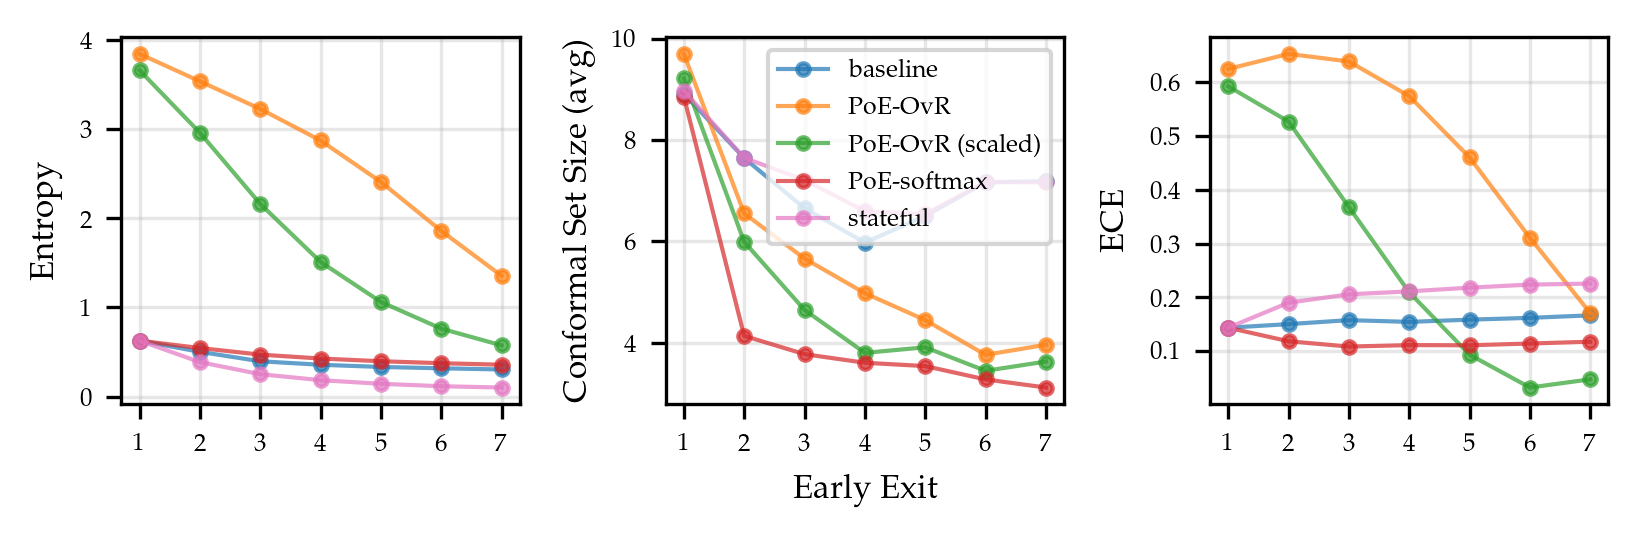

In [17]:
NAMES = [
    'baseline',
    'PoE-OvR',
    # 'MSDNet PoE-OvR (tempered)',
    'PoE-OvR (scaled)',
    'PoE-softmax',
    'stateful',
]
COLORS = [
    'tab:blue',
    'tab:orange',
    # 'tab:purple',
    'tab:green',
    'tab:red',
    'tab:pink',
]
PROBS = [
    probs,
    probs_poe_ovr_break_ties_generalized,
    # _probs_poe_ovr_break_ties_generalized_tempered,
    _probs_poe_ovr_break_ties_generalized_tempered_multi,
    probs_poe,
    probs_stateful,
]

ENTROPIES = [
    entropy_baseline,
    entropy_poe_ovr_break_ties_generalized,
    # entropy_poe_ovr_break_ties_generalized_tempered,
    entropy_poe_ovr_break_ties_generalized_tempered_multi,
    entropy_poe,
    entropy_stateful,
]

CONF_SIZES = [
    sizes_conf_sets,
    sizes_conf_sets_poe_ovr_break_ties_generalized,
    # sizes_conf_sets_poe_ovr_break_ties_generalized_tempered,
    sizes_conf_sets_poe_ovr_break_ties_generalized_tempered_multi,
    sizes_conf_sets_poe,
    sizes_conf_sets_stateful,
]



fig, ax = plt.subplots(1, 3, figsize=(text_width, text_width * 4 / 12), sharex=True)

for _entropy, label, color in zip(ENTROPIES, NAMES, COLORS):
    ax[0].plot(list(range(1, L + 1)), _entropy.mean(axis=1), marker='o', label=label, color=color, alpha=0.7)
# ax[0].set_xlabel('Early Exit')
ax[0].set_ylabel('Entropy')


for _sizes, label, color in zip(CONF_SIZES, NAMES, COLORS):
    ax[1].plot(list(range(1, L + 1)), _sizes, marker='o', label=label, color=color, alpha=0.7)
ax[1].set_xlabel('Early Exit')
ax[1].set_ylabel('Conformal Set Size (avg)')
ax[1].set_xticks(list(range(1, L + 1)))


for _probs, label, color in zip(PROBS, NAMES, COLORS):
    eces = []
    eces_rm = []
    for l in range(L):
        # eces.append(ECE(bins=15).measure(_probs[l, :, :].numpy(), targets.numpy()))
        ece = rm.metrics.ExpectedCalibrationError(num_bins=15)
        ece.add_batch(_probs[l, :, :].numpy(), label=targets.numpy())
        eces_rm.append(ece.result()['ece'])
    # ax[2].plot(list(range(1, L + 1)), eces, '-', marker='o', label=label, color=color, alpha=0.5)
    ax[2].plot(list(range(1, L + 1)), eces_rm, '-', marker='o', label=label, color=color, alpha=0.7)
# ax[2].set_xlabel('Early Exit')
ax[2].set_ylabel('ECE')

ax[1].legend()



plt.tight_layout()
plt.savefig(f'figures/figure_4_raps.pdf', dpi=1200, bbox_inches='tight')
plt.show()

baseline {0.01: 66.95, 0.05: 55.589999999999996, 0.1: 48.94, 0.2: 40.39, 0.5: 19.79}
PoE-OvR {0.01: 0.12, 0.05: 0.0, 0.1: 0.0, 0.2: 0.0, 0.5: 0.0}
PoE-OvR (single T) {0.01: 2.81, 0.05: 0.76, 0.1: 0.13999999999999999, 0.2: 0.01, 0.5: 0.0}
PoE-OvR (temp) {0.01: 8.55, 0.05: 2.85, 0.1: 0.7100000000000001, 0.2: 0.01, 0.5: 0.0}
PoE-softmax {0.01: 43.1, 0.05: 29.13, 0.1: 18.65, 0.2: 7.57, 0.5: 0.51}
stateful {0.01: 10.76, 0.05: 9.41, 0.1: 7.86, 0.2: 6.0, 0.5: 2.71}


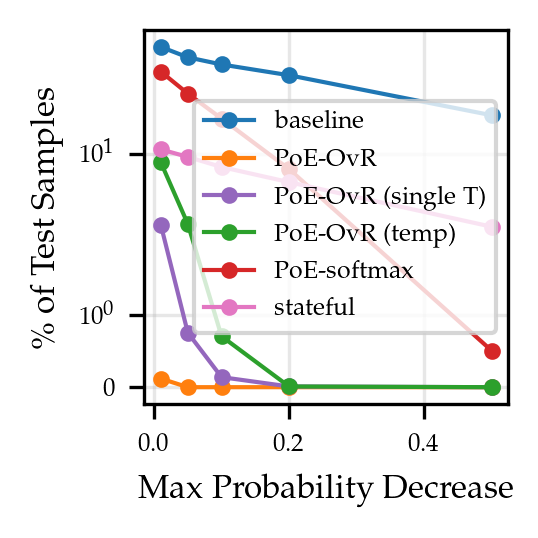

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(text_width/3, text_width/3))

_NAMES = [
    'baseline',
    'PoE-OvR',
    'PoE-OvR (single T)',
    'PoE-OvR (temp)',
    'PoE-softmax',
    'stateful',
]
_COLORS = [
    'tab:blue',
    'tab:orange',
    'tab:purple',
    'tab:green',
    'tab:red',
    'tab:pink',
]
_PROBS = [
    probs,
    probs_poe_ovr_break_ties_generalized,
    _probs_poe_ovr_break_ties_generalized_tempered,
    _probs_poe_ovr_break_ties_generalized_tempered_multi,
    probs_poe,
    probs_stateful,
]

for _probs, label, color in zip(_PROBS, _NAMES, _COLORS):
    preds = _probs.argmax(dim=-1)
    modal_probs = modal_probs_decreasing(preds, _probs, L, N=N)
    print(label, modal_probs)

    ax.plot(modal_probs.keys(), modal_probs.values(), marker='o', label=label, color=color, alpha=1)

ax.set_xlabel('Max Probability Decrease')
ax.set_ylabel('\% of Test Samples')
ax.legend()
# set log scale
ax.set_yscale('symlog')

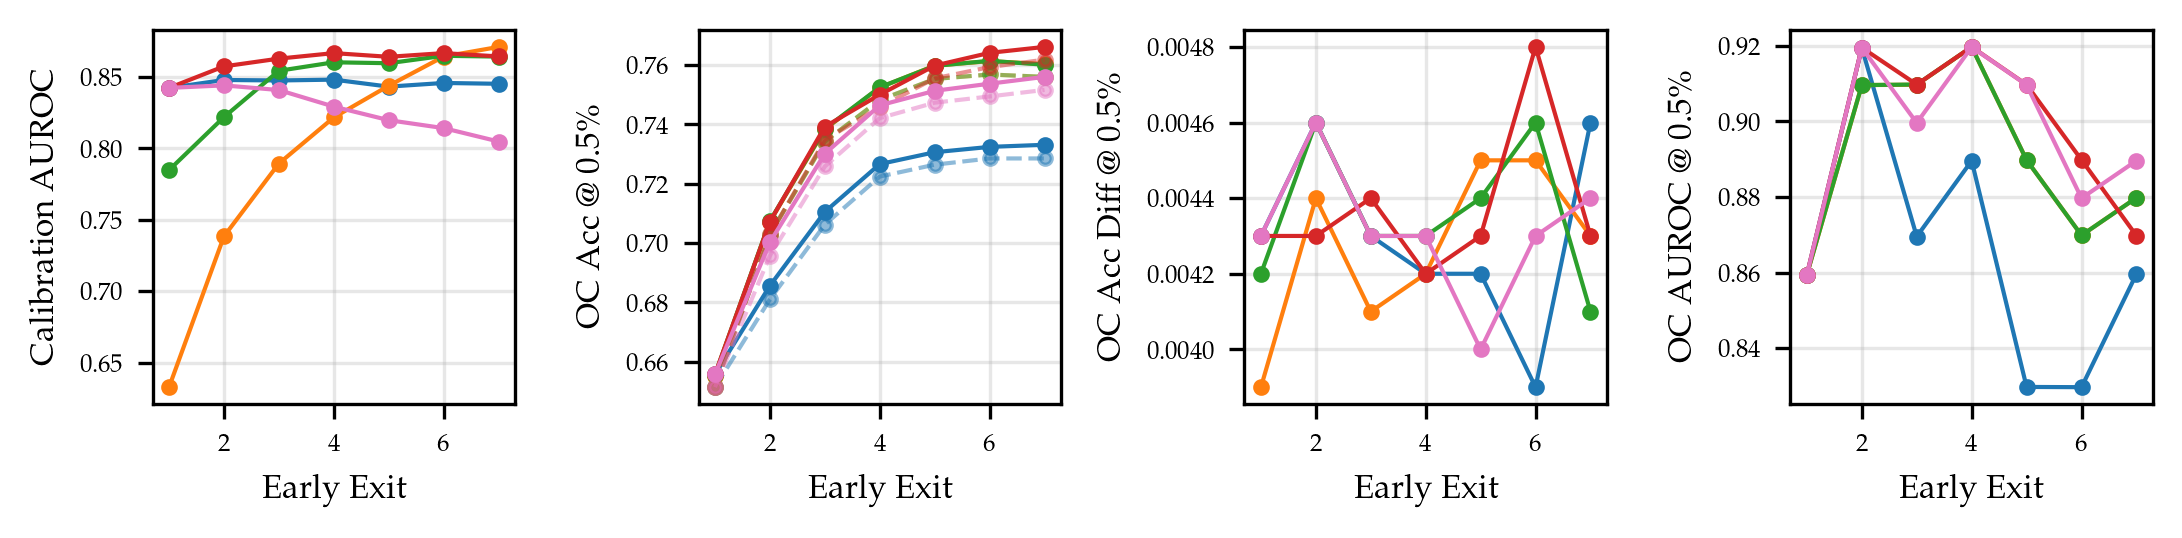

In [19]:
# FONT_SIZE = 12
# plt.rcParams.update({'font.size': FONT_SIZE})


fig, ax = plt.subplots(1, 4, figsize=(1.33*text_width, text_width / 3))

for _probs, label, color in zip(PROBS, NAMES, COLORS):
    calib_aucs = []
    for l in range(L):
        calib_auc = rm.metrics.CalibrationAUC(correct_pred_as_pos_label=False, curve='ROC')
        _preds = _probs[l, :, :].numpy().argmax(axis=-1)
        calib_auc.add_batch(_preds, label=targets.numpy(), confidence=_probs[l, :, :].numpy().max(axis=-1))
        calib_aucs.append(calib_auc.result()['calibration_auc'])
    ax[0].plot(list(range(1, L + 1)), calib_aucs, marker='o', label=label, color=color)
ax[0].set_xlabel('Early Exit')
ax[0].set_ylabel('Calibration AUROC')
# ax[0].legend()




FRACTION = 0.005


for _probs, label, color in zip(PROBS, NAMES, COLORS):
    oracle_accs = []
    accs = []
    for l in range(L):
        oracle_accs.append(oracle_collab_acc_np(
            _probs[l, :, :].numpy().argmax(axis=-1),
            targets.numpy(),
            _probs[l, :, :].numpy().max(axis=-1), 
            FRACTION, 
            diff=False))
        accs.append(oracle_collab_acc_np(
            _probs[l, :, :].numpy().argmax(axis=-1),
            targets.numpy(),
            _probs[l, :, :].numpy().max(axis=-1),
            0.,
            diff=False))

    ax[1].plot(list(range(1, L + 1)), oracle_accs, marker='o', label=label, color=color, alpha=1)
    ax[1].plot(list(range(1, L + 1)), accs, '--', marker='o', label=label, color=color, alpha=0.5)
ax[1].set_xlabel('Early Exit')
ax[1].set_ylabel(f'OC Acc @ {FRACTION * 100}\%')
# create legend to compare the two lines: solid (oracle colaborative) and dashed (baseline)
# ax[1].legend([
#     matplotlib.lines.Line2D([0], [0], color='black', lw=1, linestyle='-', alpha=1),
#     matplotlib.lines.Line2D([0], [0], color='black', lw=1, linestyle='--', alpha=0.5)],
#     ['Oracle Collaborative', 'Baseline']
#     )


for _probs, label, color in zip(PROBS, NAMES, COLORS):
    oracle_accs = []
    for l in range(L):
        oracle_accs.append(oracle_collab_acc_np(
            _probs[l, :, :].numpy().argmax(axis=-1),
            targets.numpy(),
            _probs[l, :, :].numpy().max(axis=-1), 
            FRACTION, 
            diff=True))

    ax[2].plot(list(range(1, L + 1)), oracle_accs, marker='o', label=label, color=color, alpha=1)
ax[2].set_xlabel('Early Exit')
ax[2].set_ylabel(f'OC Acc Diff @ {FRACTION * 100}\%')



FRACTION = 0.005

for _probs, label, color in zip(PROBS, NAMES, COLORS):
    oracle_aucs = []
    for l in range(L):
        _preds = _probs[l, :, :].numpy().argmax(axis=-1)

        oracle_auc = rm.metrics.OracleCollaborativeAUC(oracle_fraction=FRACTION,
                                                        num_bins=1000)
        oracle_auc.add_batch(_preds, label=targets.numpy(), custom_binning_score=_probs[l, :, :].numpy().max(axis=-1))
        oracle_aucs.append(oracle_auc.result()['collaborative_auc'])

    ax[3].plot(list(range(1, L + 1)), oracle_aucs, '-', marker='o',  label=label, alpha=1., color=color)
ax[3].set_xlabel('Early Exit')
ax[3].set_ylabel(f'OC AUROC @ {FRACTION * 100}\%')



plt.tight_layout()
plt.savefig(f'figures/figure_4b.pdf', dpi=1200)
plt.show()

In [20]:
svhn_ood_logits, _, _ = get_logits_targets('cifar100', MODEL_FOLDER, LIKELIHOOD, EPOCH, ood_dataset='svhn')
cifar10_ood_logits, _, _ = get_logits_targets('cifar100', MODEL_FOLDER, LIKELIHOOD, EPOCH, ood_dataset='cifar10')

building network of steps: 
[4, 2, 2, 2, 2, 2, 2] 16
 ********************** Block 1  **********************
|		inScales 3 outScales 3 inChannels 16 outChannels 6		|

|		inScales 3 outScales 3 inChannels 22 outChannels 6		|

|		inScales 3 outScales 3 inChannels 28 outChannels 6		|

|		inScales 3 outScales 3 inChannels 34 outChannels 6		|

 ********************** Block 2  **********************
|		inScales 3 outScales 3 inChannels 40 outChannels 6		|

|		inScales 3 outScales 3 inChannels 46 outChannels 6		|

 ********************** Block 3  **********************
|		inScales 3 outScales 2 inChannels 52 outChannels 6		|
|		Transition layer inserted! (max), inChannels 58, outChannels 29	|

|		inScales 2 outScales 2 inChannels 29 outChannels 6		|

 ********************** Block 4  **********************
|		inScales 2 outScales 2 inChannels 35 outChannels 6		|

|		inScales 2 outScales 2 inChannels 41 outChannels 6		|

 ********************** Block 5  **********************
|		inScales 2 outS

In [21]:
# baseline scores
svhn_ood_probs = torch.softmax(svhn_ood_logits, dim=2)
cifar10_ood_probs = torch.softmax(cifar10_ood_logits, dim=2)

(_, msp_baseline) = get_ood_scores(probs) # entropy baseline is already calculated
(cifar10_ood_entropy_baseline, cifar10_ood_msp_baseline) = get_ood_scores(cifar10_ood_probs)
(svhn_ood_entropy_baseline, svhn_ood_msp_baseline) = get_ood_scores(svhn_ood_probs)


# PoE scores
svhn_ood_probs_poe_ovr_break_ties_generalized = torch.tensor(f_probs_ovr_poe_logits_weighted_generalized(svhn_ood_logits, weights=(np.arange(1, L + 1, 1, dtype=float) / L) * T))
cifar10_ood_probs_poe_ovr_break_ties_generalized = torch.tensor(f_probs_ovr_poe_logits_weighted_generalized(cifar10_ood_logits, weights=(np.arange(1, L + 1, 1, dtype=float) / L) * T))

(_, msp_poe_ovr_break_ties_generalized) = get_ood_scores(probs_poe_ovr_break_ties_generalized)
(cifar10_ood_entropy_poe_ovr_break_ties_generalized, cifar10_ood_msp_poe_ovr_break_ties_generalized) = get_ood_scores(cifar10_ood_probs_poe_ovr_break_ties_generalized)
(svhn_ood_entropy_poe_ovr_break_ties_generalized, svhn_ood_msp_poe_ovr_break_ties_generalized) = get_ood_scores(svhn_ood_probs_poe_ovr_break_ties_generalized)

# PoE tempered scores
svhn_ood_probs_poe_ovr_break_ties_generalized_tempered = temper_probs(svhn_ood_probs_poe_ovr_break_ties_generalized, .5)
cifar10_ood_probs_poe_ovr_break_ties_generalized_tempered = temper_probs(cifar10_ood_probs_poe_ovr_break_ties_generalized, .5)

(_, msp_poe_ovr_break_ties_generalized_tempered) = get_ood_scores(_probs_poe_ovr_break_ties_generalized_tempered)
(cifar10_ood_entropy_poe_ovr_break_ties_generalized_tempered, cifar10_ood_msp_poe_ovr_break_ties_generalized_tempered) = get_ood_scores(cifar10_ood_probs_poe_ovr_break_ties_generalized_tempered)
(svhn_ood_entropy_poe_ovr_break_ties_generalized_tempered, svhn_ood_msp_poe_ovr_break_ties_generalized_tempered) = get_ood_scores(svhn_ood_probs_poe_ovr_break_ties_generalized_tempered)

# PoE tempered multi scores
svhn_ood_probs_poe_ovr_break_ties_generalized_tempered_multi = temper_probs(svhn_ood_probs_poe_ovr_break_ties_generalized, np.array([0.20, 0.25 ,0.30, 0.35, 0.4, 0.45, 0.5])[:, None, None])
cifar10_ood_probs_poe_ovr_break_ties_generalized_tempered_multi = temper_probs(cifar10_ood_probs_poe_ovr_break_ties_generalized, np.array([0.20, 0.25 ,0.30, 0.35, 0.4, 0.45, 0.5])[:, None, None])

(_, msp_poe_ovr_break_ties_generalized_tempered_multi) = get_ood_scores(_probs_poe_ovr_break_ties_generalized_tempered_multi)
(cifar10_ood_entropy_poe_ovr_break_ties_generalized_tempered_multi, cifar10_ood_msp_poe_ovr_break_ties_generalized_tempered_multi) = get_ood_scores(cifar10_ood_probs_poe_ovr_break_ties_generalized_tempered_multi)
(svhn_ood_entropy_poe_ovr_break_ties_generalized_tempered_multi, svhn_ood_msp_poe_ovr_break_ties_generalized_tempered_multi) = get_ood_scores(svhn_ood_probs_poe_ovr_break_ties_generalized_tempered_multi)

# PoE softmax scores
svhn_ood_logits_poe = svhn_ood_logits.cumsum(dim=0) / torch.tensor([float(x) for x in range(1, L + 1)])[:, None, None]
svhn_ood_probs_poe = torch.softmax(svhn_ood_logits_poe, dim=2)

cifar10_ood_logits_poe = cifar10_ood_logits.cumsum(dim=0) / torch.tensor([float(x) for x in range(1, L + 1)])[:, None, None]
cifar10_ood_probs_poe = torch.softmax(cifar10_ood_logits_poe, dim=2)

(_, msp_poe) = get_ood_scores(probs_poe)
(cifar10_ood_entropy_poe, cifar10_ood_msp_poe) = get_ood_scores(cifar10_ood_probs_poe)
(svhn_ood_entropy_poe, svhn_ood_msp_poe) = get_ood_scores(svhn_ood_probs_poe)

# stateful scores
svhn_ood_probs_stateful = make_stateful(svhn_ood_probs)
cifar10_ood_probs_stateful = make_stateful(cifar10_ood_probs)

(_, msp_stateful) = get_ood_scores(probs_stateful)
(cifar10_ood_entropy_stateful, cifar10_ood_msp_stateful) = get_ood_scores(cifar10_ood_probs_stateful)
(svhn_ood_entropy_stateful, svhn_ood_msp_stateful) = get_ood_scores(svhn_ood_probs_stateful)

In [22]:
svhn_ood_entropy_baseline.shape

(7, 26032)

In [23]:
entropy_baseline.shape

(7, 10000)

In [24]:

# calculate the AUCs
ood_aucs = {
    'baseline': {'cifar10': {'entropy': [], 'msp': []}, 'svhn': {'entropy': [], 'msp': []}},
    'poe_ovr_break_ties_generalized': {'cifar10': {'entropy': [], 'msp': []}, 'svhn': {'entropy': [], 'msp': []}},
    'poe_ovr_break_ties_generalized_tempered': {'cifar10': {'entropy': [], 'msp': []}, 'svhn': {'entropy': [], 'msp': []}},
    'poe_ovr_break_ties_generalized_tempered_multi': {'cifar10': {'entropy': [], 'msp': []}, 'svhn': {'entropy': [], 'msp': []}},
    'poe': {'cifar10': {'entropy': [], 'msp': []}, 'svhn': {'entropy': [], 'msp': []}},
    'stateful': {'cifar10': {'entropy': [], 'msp': []}, 'svhn': {'entropy': [], 'msp': []}},
}

for method in ood_aucs:
    for dataset in ood_aucs[method]:
        for score in ood_aucs[method][dataset]:
            for i in range(0, L):
                mul = -1 if score == 'msp' else 1
                id_score = eval('{}_{}'.format(score, method))[i]
                ood_score = eval('{}_ood_{}_{}'.format(dataset, score, method))[i]
                ood_aucs[method][dataset][score].append(get_ood_detection_roc(mul * id_score, mul * ood_score)[2])

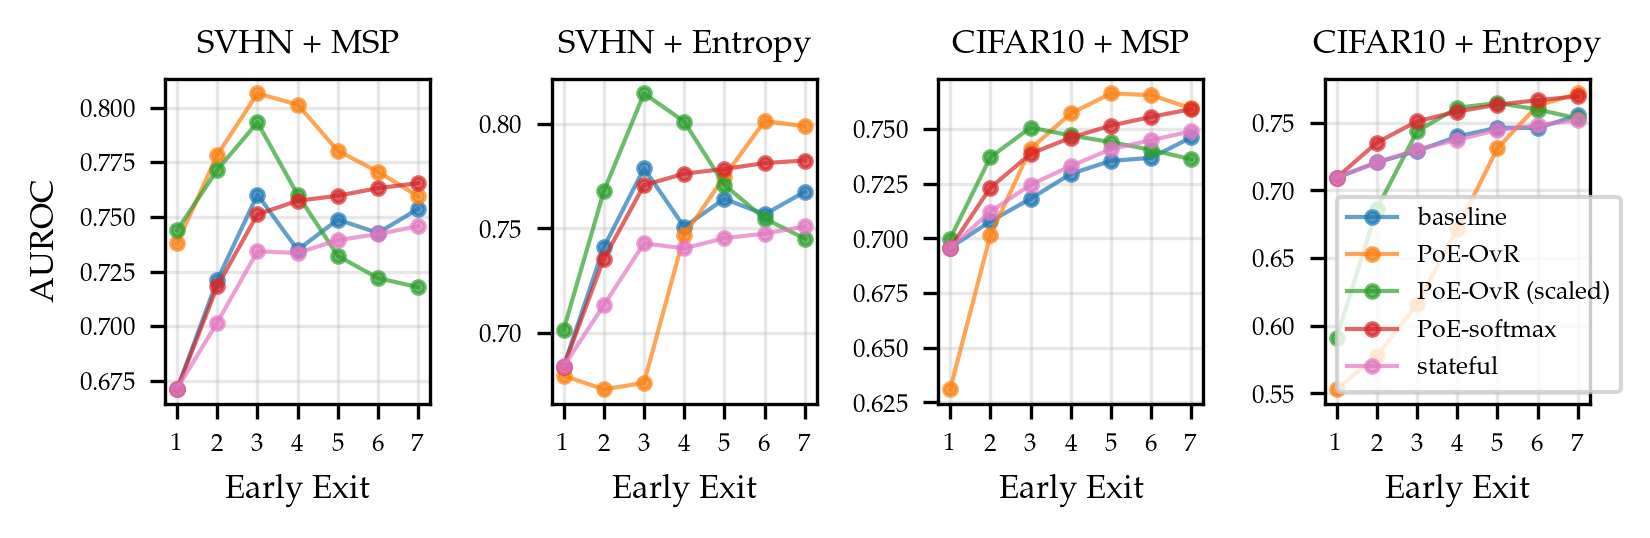

In [25]:
# make plots showing the OOD results. We will have 4 plots showing all the combinations of datasets (SVHN and CIFAR10)
# and OOD scores (entropy, MSP). Each plot will have 5 lines, one for each of the 5 methods (baseline, PoE, PoE tempered, PoE softmax, PoE tempered multi)

# NAMES = [
#     'baseline',
#     'PoE-OvR',
#     # 'PoE-OvR (single temp)',
#     'PoE-OvR (temp)',
#     'PoE-softmax',
#     'stateful'
# ]
# COLORS = [
#     'tab:blue',
#     'tab:orange',
#     # 'tab:purple',
#     'tab:green',
#     'tab:red',
#     'tab:pink',
# ]
AUCS = [
    ood_aucs['baseline'],
    ood_aucs['poe_ovr_break_ties_generalized'],
    # ood_aucs['poe_ovr_break_ties_generalized_tempered'],
    ood_aucs['poe_ovr_break_ties_generalized_tempered_multi'],
    ood_aucs['poe'],
    ood_aucs['stateful'],
]

fig, ax = plt.subplots(1, 4, figsize=(text_width, text_width / 3), sharex=True)

# SVHN + MSP
for aucs, name, color in zip(AUCS, NAMES, COLORS):
    ax[0].plot(np.arange(1, L + 1), aucs['svhn']['msp'], color=color, label=name, marker='o', alpha=0.7)
ax[0].set_title('SVHN + MSP')
ax[0].set_xlabel('Early Exit')
ax[0].set_ylabel('AUROC')
# ax[0].legend()
ax[0].set_xticks(np.arange(1, L + 1))

# SVHN + entropy
for aucs, name, color in zip(AUCS, NAMES, COLORS):
    ax[1].plot(np.arange(1, L + 1), aucs['svhn']['entropy'], color=color, label=name, marker='o', alpha=0.7)
ax[1].set_title('SVHN + Entropy')
ax[1].set_xlabel('Early Exit')
# ax[1].set_ylabel('AUROC')


# CIFAR10 + MSP
for aucs, name, color in zip(AUCS, NAMES, COLORS):
    ax[2].plot(np.arange(1, L + 1), aucs['cifar10']['msp'], color=color, label=name, marker='o', alpha=0.7)
ax[2].set_title('CIFAR10 + MSP')
ax[2].set_xlabel('Early Exit')
# ax[2].set_ylabel('AUROC')

# CIFAR10 + entropy
for aucs, name, color in zip(AUCS, NAMES, COLORS):
    ax[3].plot(np.arange(1, L + 1), aucs['cifar10']['entropy'], color=color, label=name, marker='o', alpha=0.7)
ax[3].set_title('CIFAR10 + Entropy')
ax[3].set_xlabel('Early Exit')
# ax[3].set_ylabel('AUROC')

ax[3].legend()

plt.tight_layout()
# plt.savefig(f'figures/figure_4b.pdf', dpi=1200)
plt.show()

## Paper Plot

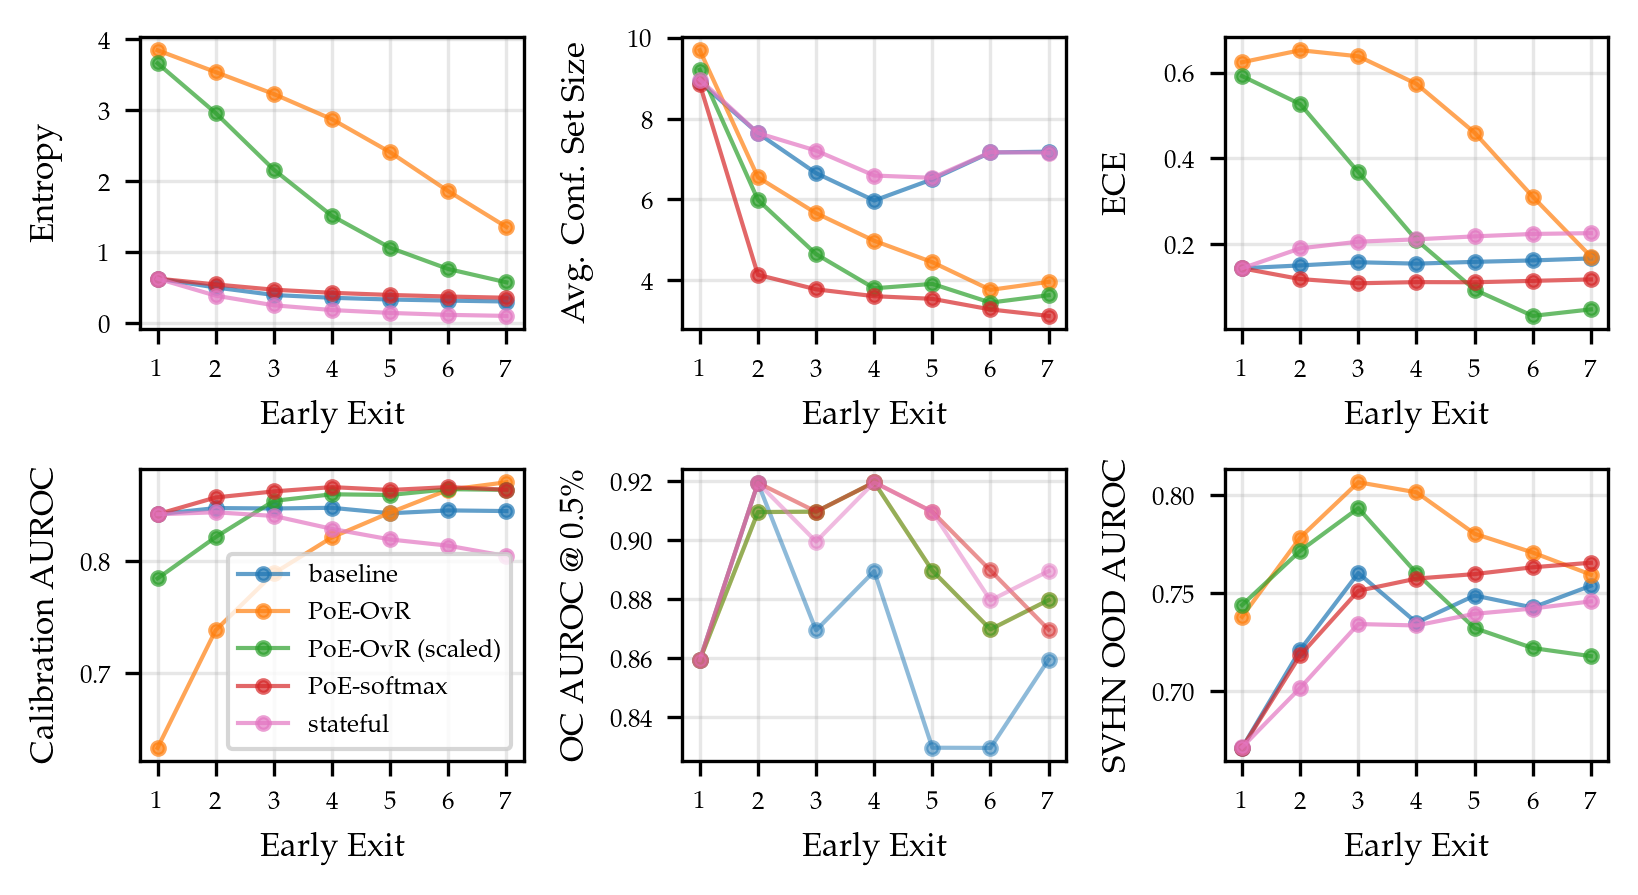

In [33]:
fig, ax = plt.subplots(2, 3, figsize=(text_width, text_width * 0.55), sharex=False)

for _entropy, label, color in zip(ENTROPIES, NAMES, COLORS):
    ax[0, 0].plot(list(range(1, L + 1)), _entropy.mean(axis=1), marker='o', label=label, color=color, alpha=0.7)
ax[0, 0].set_ylabel('Entropy')


for _sizes, label, color in zip(CONF_SIZES, NAMES, COLORS):
    ax[0, 1].plot(list(range(1, L + 1)), _sizes, marker='o', label=label, color=color, alpha=0.7)
ax[0, 1].set_ylabel('Avg. Conf. Set Size')


for _probs, label, color in zip(PROBS, NAMES, COLORS):
    eces = []
    eces_rm = []
    for l in range(L):
        ece = rm.metrics.ExpectedCalibrationError(num_bins=15)
        ece.add_batch(_probs[l, :, :].numpy(), label=targets.numpy())
        eces_rm.append(ece.result()['ece'])
    ax[0, 2].plot(list(range(1, L + 1)), eces_rm, '-', marker='o', label=label, color=color, alpha=0.7)
ax[0, 2].set_ylabel('ECE')



for _probs, label, color in zip(PROBS, NAMES, COLORS):
    calib_aucs = []
    for l in range(L):
        calib_auc = rm.metrics.CalibrationAUC(correct_pred_as_pos_label=False, curve='ROC')
        _preds = _probs[l, :, :].numpy().argmax(axis=-1)
        calib_auc.add_batch(_preds, label=targets.numpy(), confidence=_probs[l, :, :].numpy().max(axis=-1))
        calib_aucs.append(calib_auc.result()['calibration_auc'])
    ax[1, 0].plot(list(range(1, L + 1)), calib_aucs, marker='o', label=label, color=color, alpha=0.7)
ax[1, 0].set_ylabel('Calibration AUROC')


FRACTION = 0.005
for _probs, label, color in zip(PROBS, NAMES, COLORS):
    oracle_aucs = []
    for l in range(L):
        _preds = _probs[l, :, :].numpy().argmax(axis=-1)

        oracle_auc = rm.metrics.OracleCollaborativeAUC(oracle_fraction=FRACTION,
                                                        num_bins=1000)
        oracle_auc.add_batch(_preds, label=targets.numpy(), custom_binning_score=_probs[l, :, :].numpy().max(axis=-1))
        oracle_aucs.append(oracle_auc.result()['collaborative_auc'])

    ax[1, 1].plot(list(range(1, L + 1)), oracle_aucs, '-', marker='o',  label=label, alpha=.5, color=color)
ax[1, 1].set_ylabel(f'OC AUROC @ {FRACTION * 100}\%')


for aucs, name, color in zip(AUCS, NAMES, COLORS):
    ax[1, 2].plot(np.arange(1, L + 1), aucs['svhn']['msp'], color=color, label=name, marker='o', alpha=0.7)
ax[1, 2].set_ylabel('SVHN OOD AUROC')



for (i, j) in itertools.product(range(2), range(3)):
    ax[i, j].set_xticks(list(range(1, L + 1)))
    ax[i, j].set_xlabel('Early Exit')



ax[1, 0].legend()

fig.align_ylabels(ax)


plt.tight_layout()
plt.savefig(f'figures/figure_4_paper.pdf', dpi=1200, bbox_inches='tight')
plt.show()

baseline {0.01: 66.95, 0.05: 55.589999999999996, 0.1: 48.94, 0.2: 40.39, 0.5: 19.79}
PoE-OvR {0.01: 0.12, 0.05: 0.0, 0.1: 0.0, 0.2: 0.0, 0.5: 0.0}
PoE-OvR (scaled) {0.01: 8.55, 0.05: 2.85, 0.1: 0.7100000000000001, 0.2: 0.01, 0.5: 0.0}
PoE-softmax {0.01: 43.1, 0.05: 29.13, 0.1: 18.65, 0.2: 7.57, 0.5: 0.51}
stateful {0.01: 10.76, 0.05: 9.41, 0.1: 7.86, 0.2: 6.0, 0.5: 2.71}


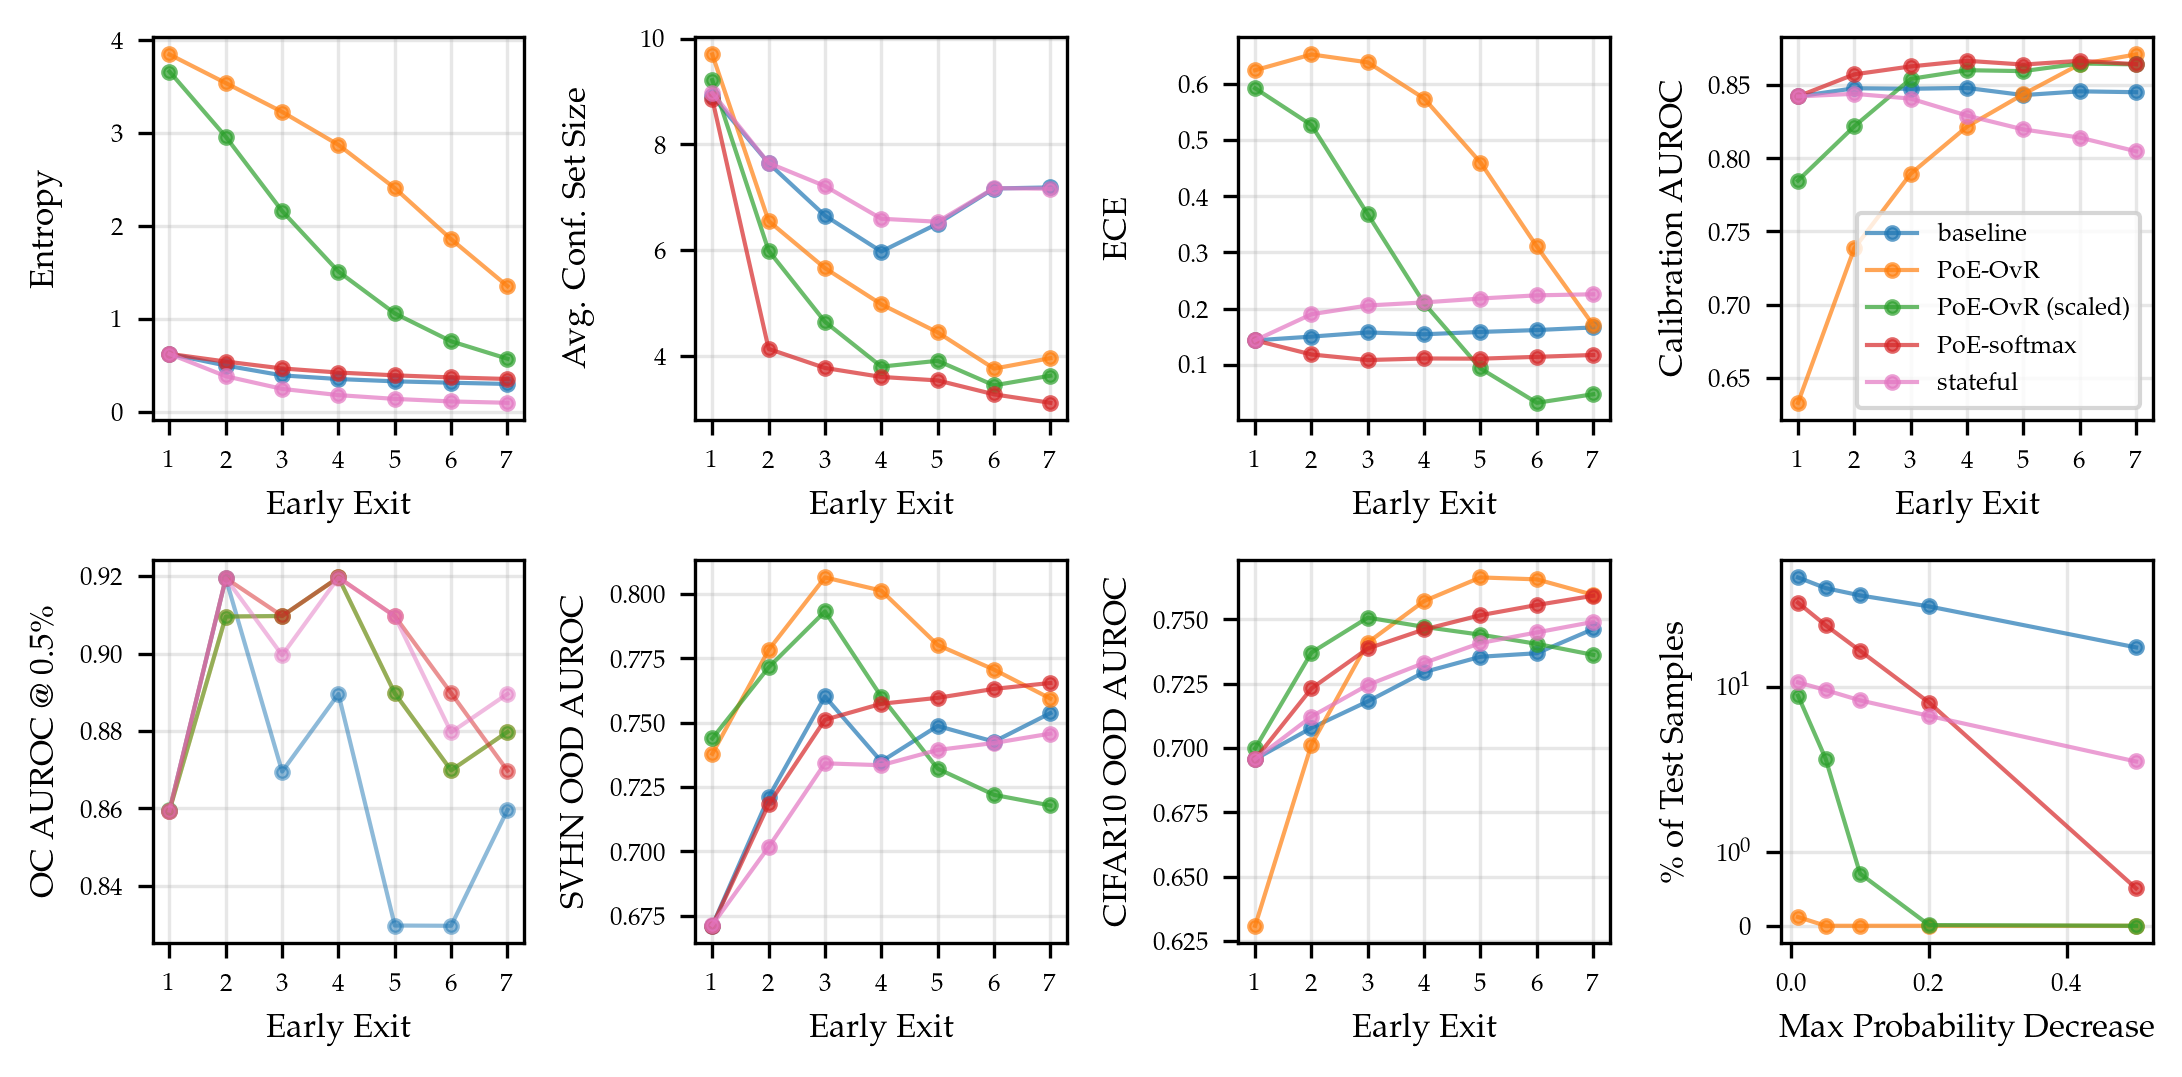

In [34]:
fig, ax = plt.subplots(2, 4, figsize=(1.33*text_width, text_width * 0.66), sharex=False)

for _entropy, label, color in zip(ENTROPIES, NAMES, COLORS):
    ax[0, 0].plot(list(range(1, L + 1)), _entropy.mean(axis=1), marker='o', label=label, color=color, alpha=0.7)
ax[0, 0].set_ylabel('Entropy')


for _sizes, label, color in zip(CONF_SIZES, NAMES, COLORS):
    ax[0, 1].plot(list(range(1, L + 1)), _sizes, marker='o', label=label, color=color, alpha=0.7)
ax[0, 1].set_ylabel('Avg. Conf. Set Size')


for _probs, label, color in zip(PROBS, NAMES, COLORS):
    eces = []
    eces_rm = []
    for l in range(L):
        ece = rm.metrics.ExpectedCalibrationError(num_bins=15)
        ece.add_batch(_probs[l, :, :].numpy(), label=targets.numpy())
        eces_rm.append(ece.result()['ece'])
    ax[0, 2].plot(list(range(1, L + 1)), eces_rm, '-', marker='o', label=label, color=color, alpha=0.7)
ax[0, 2].set_ylabel('ECE')



for _probs, label, color in zip(PROBS, NAMES, COLORS):
    calib_aucs = []
    for l in range(L):
        calib_auc = rm.metrics.CalibrationAUC(correct_pred_as_pos_label=False, curve='ROC')
        _preds = _probs[l, :, :].numpy().argmax(axis=-1)
        calib_auc.add_batch(_preds, label=targets.numpy(), confidence=_probs[l, :, :].numpy().max(axis=-1))
        calib_aucs.append(calib_auc.result()['calibration_auc'])
    ax[0, 3].plot(list(range(1, L + 1)), calib_aucs, marker='o', label=label, color=color, alpha=0.7)
ax[0, 3].set_ylabel('Calibration AUROC')


FRACTION = 0.005
for _probs, label, color in zip(PROBS, NAMES, COLORS):
    oracle_aucs = []
    for l in range(L):
        _preds = _probs[l, :, :].numpy().argmax(axis=-1)

        oracle_auc = rm.metrics.OracleCollaborativeAUC(oracle_fraction=FRACTION,
                                                        num_bins=1000)
        oracle_auc.add_batch(_preds, label=targets.numpy(), custom_binning_score=_probs[l, :, :].numpy().max(axis=-1))
        oracle_aucs.append(oracle_auc.result()['collaborative_auc'])

    ax[1, 0].plot(list(range(1, L + 1)), oracle_aucs, '-', marker='o',  label=label, alpha=.5, color=color)
ax[1, 0].set_ylabel(f'OC AUROC @ {FRACTION * 100}\%')


for aucs, name, color in zip(AUCS, NAMES, COLORS):
    ax[1, 1].plot(np.arange(1, L + 1), aucs['svhn']['msp'], color=color, label=name, marker='o', alpha=0.7)
ax[1, 1].set_ylabel('SVHN OOD AUROC')

for aucs, name, color in zip(AUCS, NAMES, COLORS):
    ax[1, 2].plot(np.arange(1, L + 1), aucs['cifar10']['msp'], color=color, label=name, marker='o', alpha=0.7)
ax[1, 2].set_ylabel('CIFAR10 OOD AUROC')


for (i, j) in itertools.product(range(2), range(4)):
    if i == 1 and j == 3:
        continue
    ax[i, j].set_xticks(list(range(1, L + 1)))
    ax[i, j].set_xlabel('Early Exit')



for _probs, label, color in zip(PROBS, NAMES, COLORS):
    preds = _probs.argmax(dim=-1)
    modal_probs = modal_probs_decreasing(preds, _probs, L, N=N)
    print(label, modal_probs)

    ax[1, 3].plot(modal_probs.keys(), modal_probs.values(), marker='o', label=label, color=color, alpha=0.7)

ax[1, 3].set_xlabel('Max Probability Decrease')
ax[1, 3].set_ylabel('\% of Test Samples')
# set log scale
ax[1, 3].set_yscale('symlog')


ax[0, 3].legend()

fig.align_ylabels(ax)


plt.tight_layout()
plt.savefig(f'figures/figure_4_paper_with_extra.pdf', dpi=1200, bbox_inches='tight')
plt.show()

## Corrupted Cifar10